In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader


# Load the cleaned dataset
df = pd.read_csv('/content/cleaned_phishing_dataset.csv')
# Display the first few rows to confirm loading
print(df.head())
print(df.info())

                                              sender  \
0                   young esposito <young@iworld.de>   
1                       mok <ipline's1983@icable.ph>   
2  daily top 10 <karmandeep-opengevl@universalnet...   
3                 michael parker <ivqrnai@pobox.com>   
4  gretchen suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  spamassassin dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   

                                             subject  \
0                          never agree to be a loser   
1                             befriend jenna jameson   
2                                cnncom daily top 10   
3  re svn commit r619753 in spamassassintrunk lib...   
4                         specialpricespharmmoreinfo   

       

In [ ]:
# Extract domain from email
def extract_domain(email):
    match = re.search(r'@([\w.-]+)', email)
    return match.group(1) if match else "unknown"

# Extract number of digits in email
def count_digits(email):
    return sum(c.isdigit() for c in email)

# Flag suspicious domains
suspicious_tlds = {'xyz', 'top', 'info', 'click', 'win', 'shop', 'gq'}
def is_suspicious_tld(email):
    match = re.search(r'\.([a-z]+)$', email)
    return 1 if match and match.group(1) in suspicious_tlds else 0

# Check if sender name matches email username
def name_email_mismatch(sender):
    match = re.match(r'([\w\s]+)\s*<([\w.-]+)@', sender)
    if match:
        name_part = match.group(1).split()[0].lower()
        email_part = match.group(2).lower()
        return 0 if name_part in email_part else 1
    return 1



In [ ]:
# Apply email feature extractions
df['sender_domain'] = df['sender'].apply(extract_domain)
df['receiver_domain'] = df['receiver'].apply(extract_domain)
df['sender_digits'] = df['sender'].apply(count_digits)
df['receiver_digits'] = df['receiver'].apply(count_digits)
df['suspicious_sender_tld'] = df['sender'].apply(is_suspicious_tld)
df['mismatch_sender'] = df['sender'].apply(name_email_mismatch)

# Concatenate subject and body for text features
df['text'] = df['subject'] + " " + df['body']


In [ ]:
# Ensure no NaN values in text column
df['text'] = df['text'].fillna("")

# Extract n-grams using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=500)
ngrams = vectorizer.fit_transform(df['text'])

# Convert to DataFrame
ngrams_df = pd.DataFrame(ngrams.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate n-gram features with original dataset
df = pd.concat([df, ngrams_df], axis=1)


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Ensure no NaN values
df['text'] = df['text'].fillna("")
df['label'] = df['label'].fillna(0).astype(int)

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Define Dataset class
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch datasets and dataloaders
train_dataset = EmailDataset(train_texts, train_labels, tokenizer)
test_dataset = EmailDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Load pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',             # Required
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10
)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

# Define optimizer, loss function, and scheduler
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Tokenizer (if not already loaded)
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Custom dataset
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Split your dataframe
texts = df['text'].fillna("").tolist()
labels = df['label'].astype(int).tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = EmailDataset(train_texts, train_labels, tokenizer)
test_dataset = EmailDataset(test_texts, test_labels, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

    train_acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.4f}")

# Evaluation loop
model.eval()
correct, total_loss = 0, 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()
        correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

test_acc = correct / len(test_dataset)
print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/1, Loss: 0.0144, Accuracy: 1.0000
Test Loss: 2.4857, Test Accuracy: 0.9877


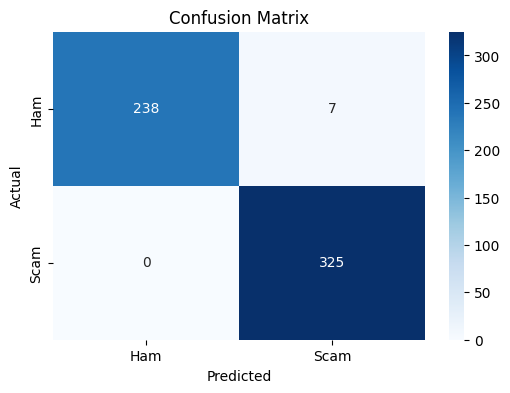


Classification Report:
               precision    recall  f1-score   support

         Ham       1.00      0.97      0.99       245
        Scam       0.98      1.00      0.99       325

    accuracy                           0.99       570
   macro avg       0.99      0.99      0.99       570
weighted avg       0.99      0.99      0.99       570

Precision: 0.9789
Recall:    1.0000
F1 Score:  0.9893


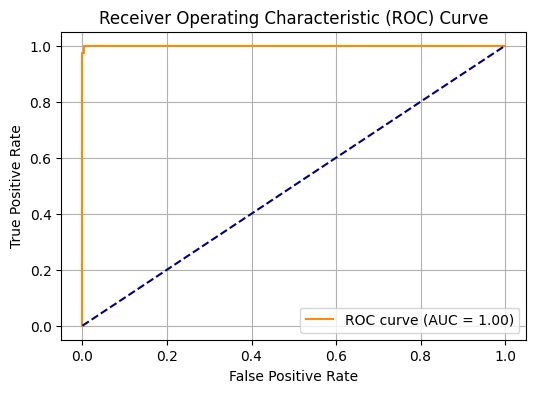

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)
import numpy as np

# === Evaluation Phase ===
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # Probability of "Scam" class
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Scam"], yticklabels=["Ham", "Scam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === Classification Report & Metrics ===
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Ham", "Scam"]))
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")

# === ROC Curve and AUC ===
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    try:
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_acc, val_loss = eval_model(model, val_loader, criterion, device)

        # Store losses and accuracies
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc.item())
        val_accuracies.append(val_acc.item())

        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    except Exception as e:
        print(f"Error in epoch {epoch + 1}: {e}")



Epoch 1/1
Error in epoch 1: name 'val_loader' is not defined


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0

    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return accuracy, avg_loss


def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return accuracy, avg_loss


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 2  # You can change this as needed

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")



Epoch 1/2
Train Loss: 0.0000, Accuracy: 1.0000
Val   Loss: 0.0160, Accuracy: 0.9947

Epoch 2/2
Train Loss: 0.0000, Accuracy: 1.0000
Val   Loss: 0.0166, Accuracy: 0.9947


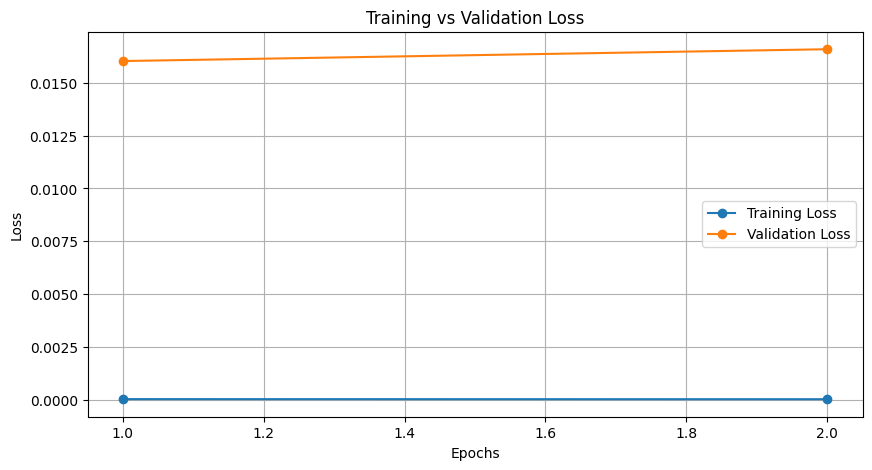

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Example blacklist/whitelist setup
blacklisted_domains = {"scammail.xyz", "winbig.click", "prizealert.top"}
whitelisted_domains = {"mycompany.com", "trustedpartner.org"}

blacklisted_keywords = {"claim now", "urgent action", "verify account", "reset password"}
whitelisted_senders = {"hr@mycompany.com", "support@trustedpartner.org"}


def get_domain(email):
    """Extract domain from email address."""
    import re
    match = re.search(r'@([\w.-]+)', email)
    return match.group(1) if match else ""


def check_blacklist_whitelist(sender_email, email_text):
    """Returns classification based on rules."""
    domain = get_domain(sender_email).lower()
    email_text_lower = email_text.lower()

    # Check whitelist
    if domain in whitelisted_domains or sender_email.lower() in whitelisted_senders:
        return "✅ Legitimate (Whitelisted)", 1.0

    # Check blacklist domain
    if domain in blacklisted_domains:
        return "🛑 Phishing (Blacklisted Domain)", 0.95

    # Check suspicious keywords
    if any(keyword in email_text_lower for keyword in blacklisted_keywords):
        return "⚠️ Likely Phishing (Suspicious Keywords)", 0.85

    return "🤖 Needs Model Prediction", None  # fallback to ML model



In [ ]:
# === DEMO EXAMPLES ===
test_emails = [
    {"sender": "hr@mycompany.com", "text": "Important: Your payslip is ready."},
    {"sender": "hacker@scammail.xyz", "text": "Claim your prize now by clicking here!"},
    {"sender": "info@randomnews.com", "text": "Reset your password to continue."},
    {"sender": "support@trustedpartner.org", "text": "Your issue has been resolved."},
    {"sender": "unknown@weirdmail.net", "text": "Check this out! You won!"}
]

for idx, email in enumerate(test_emails, 1):
    label, confidence = check_blacklist_whitelist(email['sender'], email['text'])
    print(f"📧 Email {idx} from {email['sender']}")
    print(f"➡️ Rule-Based Decision: {label}")
    if confidence is None:
        print("🔁 This email will now be passed to the ML model.\n")
    else:
        print(f"🎯 Confidence: {confidence}\n")

📧 Email 1 from hr@mycompany.com
➡️ Rule-Based Decision: ✅ Legitimate (Whitelisted)
🎯 Confidence: 1.0

📧 Email 2 from hacker@scammail.xyz
➡️ Rule-Based Decision: 🛑 Phishing (Blacklisted Domain)
🎯 Confidence: 0.95

📧 Email 3 from info@randomnews.com
➡️ Rule-Based Decision: 🤖 Needs Model Prediction
🔁 This email will now be passed to the ML model.

📧 Email 4 from support@trustedpartner.org
➡️ Rule-Based Decision: ✅ Legitimate (Whitelisted)
🎯 Confidence: 1.0

📧 Email 5 from unknown@weirdmail.net
➡️ Rule-Based Decision: 🤖 Needs Model Prediction
🔁 This email will now be passed to the ML model.



In [ ]:
import torch
from transformers import DistilBertTokenizerFast

# --- Load Tokenizer (assumes model is already loaded and on the correct device) ---
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# --- Whitelist/Blacklist Setup ---
blacklisted_domains = {"scammail.xyz", "winbig.click", "prizealert.top"}
whitelisted_domains = {"mycompany.com", "trustedpartner.org"}

blacklisted_keywords = {"claim now", "urgent action", "verify account", "reset password"}
whitelisted_senders = {"hr@mycompany.com", "support@trustedpartner.org"}

def get_domain(email):
    import re
    match = re.search(r'@([\w.-]+)', email)
    return match.group(1) if match else ""

def check_blacklist_whitelist(sender_email, email_text):
    domain = get_domain(sender_email).lower()
    email_text_lower = email_text.lower()

    if domain in whitelisted_domains or sender_email.lower() in whitelisted_senders:
        return "✅ Legitimate (Whitelisted)", 0.99

    if domain in blacklisted_domains:
        return "🛑 Phishing (Blacklisted Domain)", 0.95

    if any(keyword in email_text_lower for keyword in blacklisted_keywords):
        return "⚠️ Likely Phishing (Suspicious Keywords)", 0.85

    return "🤖 Needs Model Prediction", None

def predict_with_model(email_text):
    model.eval()
    encoding = tokenizer(email_text, truncation=True, padding='max_length', max_length=256, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_label].item()
        return "🛑 Phishing" if pred_label == 1 else "✅ Legitimate", round(confidence, 2)

# --- Sample Test Emails ---
test_emails = [
    {"sender": "hr@mycompany.com", "text": "Important: Your payslip is ready."},
    {"sender": "hacker@scammail.xyz", "text": "Claim your prize now by clicking here!"},
    {"sender": "info@randomnews.com", "text": "Reset your password to continue."},
    {"sender": "support@trustedpartner.org", "text": "Your issue has been resolved."},
    {"sender": "unknown@weirdmail.net", "text": "URGENT: Your account has been compromised. Click to fix."},
]

# --- Full Pipeline Prediction ---
for idx, email in enumerate(test_emails, 1):
    sender = email['sender']
    text = email['text']

    rule_label, rule_conf = check_blacklist_whitelist(sender, text)

    print(f"\n📧 Email {idx} from {sender}")
    print(f"📨 Content: {text}")

    if rule_conf is not None:
        print(f"➡️ Rule-Based Decision: {rule_label} (Confidence: {rule_conf})")
    else:
        ml_label, ml_conf = predict_with_model(text)
        print(f"➡️ ML-Based Decision: {ml_label} (Confidence: {ml_conf})")



📧 Email 1 from hr@mycompany.com
📨 Content: Important: Your payslip is ready.
➡️ Rule-Based Decision: ✅ Legitimate (Whitelisted) (Confidence: 0.99)

📧 Email 2 from hacker@scammail.xyz
📨 Content: Claim your prize now by clicking here!
➡️ Rule-Based Decision: 🛑 Phishing (Blacklisted Domain) (Confidence: 0.95)

📧 Email 3 from info@randomnews.com
📨 Content: Reset your password to continue.
➡️ ML-Based Decision: 🛑 Phishing (Confidence: 0.57)

📧 Email 4 from support@trustedpartner.org
📨 Content: Your issue has been resolved.
➡️ Rule-Based Decision: ✅ Legitimate (Whitelisted) (Confidence: 0.99)

📧 Email 5 from unknown@weirdmail.net
📨 Content: URGENT: Your account has been compromised. Click to fix.
➡️ ML-Based Decision: 🛑 Phishing (Confidence: 1.0)
